In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
%reload_ext autoreload
%autoreload 2

# EDA

Set a predetermined seed so all our results can be replicated

In [3]:
RANDOM_SEED = 1337

### Data Source Description
- Raw data can be downloaded from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn?resource=download
- Data was originally provided by IBM Sample Datasets with general information such as:
    - Customers who left within the last month – the column is called Churn
    - Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
    - Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
    - Demographic info about customers – gender, age range, and if they have partners and dependents 

In [103]:
full_data = pd.read_csv('Dataset/clean_data.csv',index_col='customerID')
churn = full_data['Churn'].copy()
full_data = full_data.drop('Churn',axis=1)

Data has 7043 observations and 19 features to work with. Our preprocessing script already handled and imputed all missingness.

In [20]:
full_data.shape

(7043, 19)

In [21]:
full_data.head(5)

,gender,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,1,NaN,DSL,No,Yes,No,No,No,No,Month-to-month,Electronic check,29.85,29.85,False,True,False,False,True
5575-GNVDE,Male,34,No,DSL,Yes,No,Yes,No,No,No,One year,Mailed check,56.95,1889.50,False,False,False,True,False
3668-QPYBK,Male,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Mailed check,53.85,108.15,False,False,False,True,True
7795-CFOCW,Male,45,NaN,DSL,Yes,No,Yes,Yes,No,No,One year,Bank transfer (automatic),42.30,1840.75,False,False,False,False,False
9237-HQITU,Female,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Electronic check,70.70,151.65,False,False,False,True,True


Column descriptions are scraped and cleaned from the kaggle website via beautifulsoup. It's been packaged in this repository for convenience's sake as a Json file. 

In [27]:
with open('col_desc.json','r') as f:
    col_desc = json.load(f)
    
#Shortened descriptions with elipses for plot titles
#Only retains first 20 characters of description then appends with elipses
short_col_desc = dict(zip(
    col_desc.keys(),
    map(lambda desc: 
        desc if len(desc)<20 else f'{desc[:27]}...', col_desc.values()
    )
))

# Preprocessing

In [72]:
#Get column names by dtype
num_cols = full_data.select_dtypes(np.number).columns
cat_cols = full_data.select_dtypes('object').columns
bin_cols = full_data.select_dtypes(bool).columns

# Target Column

We see that our target variable is quite imbalanced, hence we will have to take measures against this when training the models later on

<AxesSubplot: ylabel='Churn'>

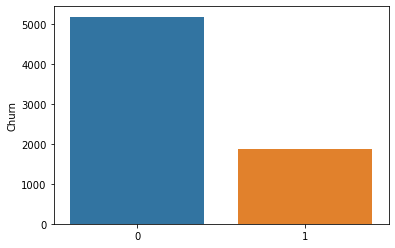

In [72]:
sns.barplot(x=churn.value_counts().index,y=churn.value_counts())

# Univariate Analysis

We first take a look at the distributions of each variable just to get an idea of what we're working with

### Numerical Columns

In [25]:
from graph_utils import get_subplot_dim

We can make the following observations from the distribution of our three numerical columns:
- Both "Tenure" and "Monthly Charge" seems to have a roughly bimodal distribution, both with dips at value 40 
    - We can therefore roughly separate our customers between new and old at around the 40 months mark
    - We can also roughly separate our customers between budget and premium at around the $40 dollars mark
- Total Charges has a right skew distribution

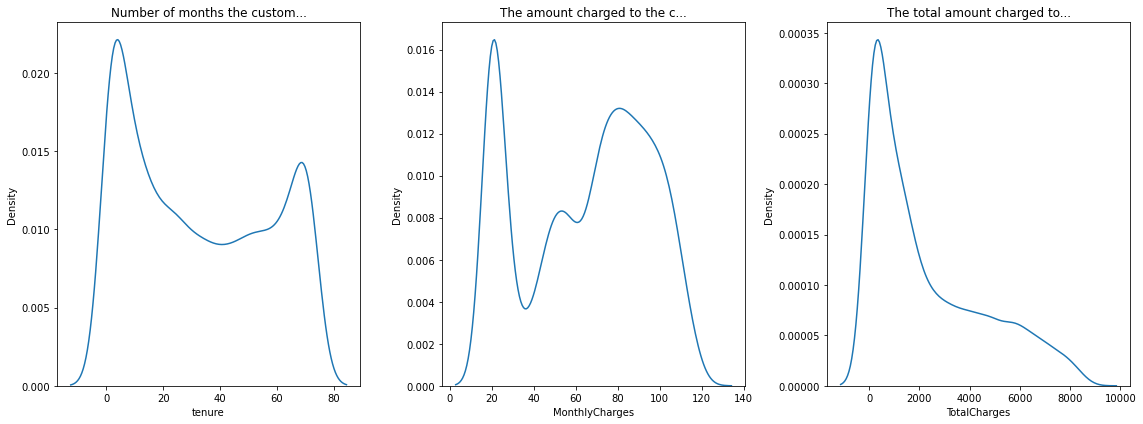

In [73]:
r, c = get_subplot_dim(len(num_cols))
fig, ax = plt.subplots(r,c,figsize=(16,6))
for col, subplot in zip(num_cols,ax.flatten()):
    sub_ax = sns.kdeplot(x=full_data[col],ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

### Categorical Columns

We can make the following interesting observations from the distribution of our categorical columns:
- We have a pretty good balance of genders
- Most customers are sign month-to-month contracts. Since the granularity of our data is month-to-month as well, it means any countermeasures we take against churn will need to be automated and react quickly to be of use. 

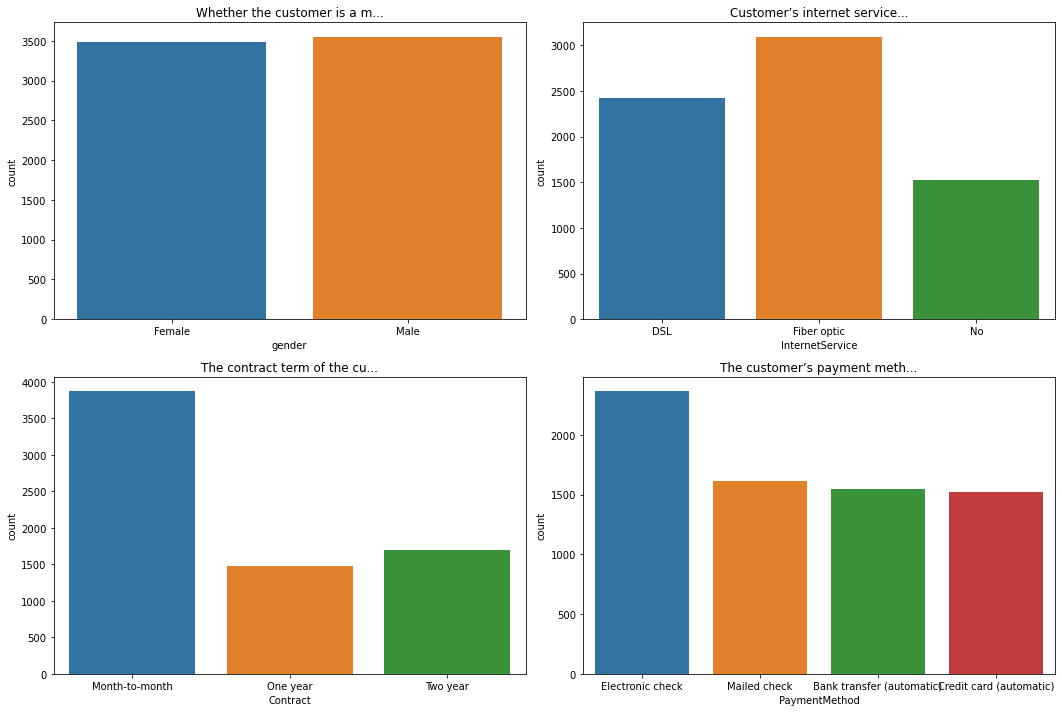

In [74]:
r, c = get_subplot_dim(len(cat_cols))
fig, ax = plt.subplots(r,c,figsize=(15,10))
for col, subplot in zip(cat_cols,ax.flatten()):
    sub_ax = sns.countplot(x=full_data[col],ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

### Binary Columns

It seems like most of our binary features are quite imbalanced. 

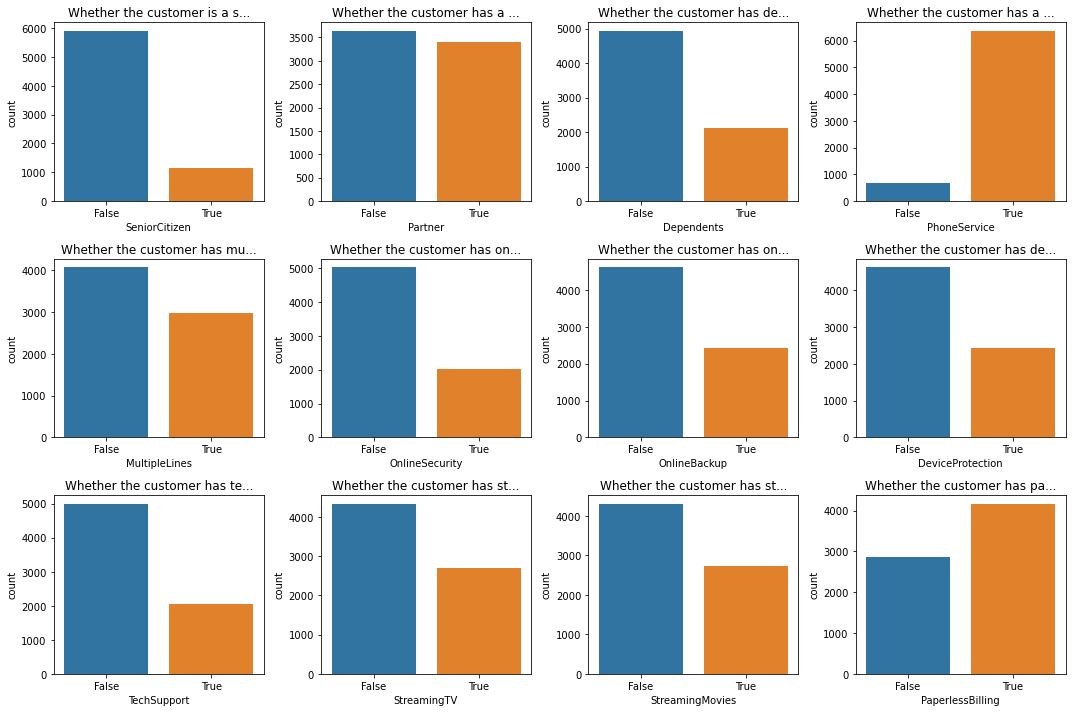

In [75]:
r, c = get_subplot_dim(len(bin_cols))
fig, ax = plt.subplots(r,c,figsize=(15,10))
for col, subplot in zip(bin_cols,ax.flatten()):
    sub_ax = sns.countplot(x=full_data[col],ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

Furthermore, in the preprocessing script we had to separate certain columns' dependency on others. For example, whenever a customer did not purchase Internet Service, the columns that depended on it would say "no internet service". Such cases are coded as False within the dependent columns for ease of processing. The columns that are depended upon and their respective dependent columns are listed below, which we can reproduce via looking at column descriptions. 
 1. Phone Service
    - MultipleLines
 2. Internet Service
    - OnlineSecurity, OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies, TechSupport

In [257]:
col_desc_ser = pd.Series(col_desc).rename('col_desc')

In [258]:
#Save the cols for later use
phone_cols = col_desc_ser.index[col_desc_ser.str.contains('phone service')]
internet_cols = col_desc_ser.index[col_desc_ser.str.contains('internet service')]

# Multivariate Analysis

In [ ]:
# One-Hot encodes our categorical variables so we can create calculate corrs
cpu_readable_data = (
    full_data[num_cols]
    .join(full_data[bin_cols])
    .join(
        pd.get_dummies(full_data[cat_cols])
))

We can calculate pearson's correlation coefficient for different values in our data with churn

In [82]:
churn_corrs = (
    cpu_readable_data.join(churn)
    .corr()
    .drop('Churn')['Churn'].sort_values()
)

From the correlation bar plot below we can see that:
 - As expected, the longer you have been with the company (tenure) the less likely you are to churn (negative correlation)
 - Contract type (Month-to-Month, One Year, Two year) also affects churn rates as expected where longer contracts mean less churn
 - Gender has no obvious effect on churn rates
 - Interestingly, customers who are more tech savvy (Uses Fiber Optics, Electronic Check, and Paperless Billing) are more likely to churn
    - However, those who enroll in automatic credit card payments are much less likely to churn, likely as these types of customers simply setup their accounts and don't pay much attention to their phone bills hence don't shop around as much
 - Senior Citizens seem more likely to churn
 - Those with a partner or dependent seem less likely to churn

<AxesSubplot: xlabel='Churn'>

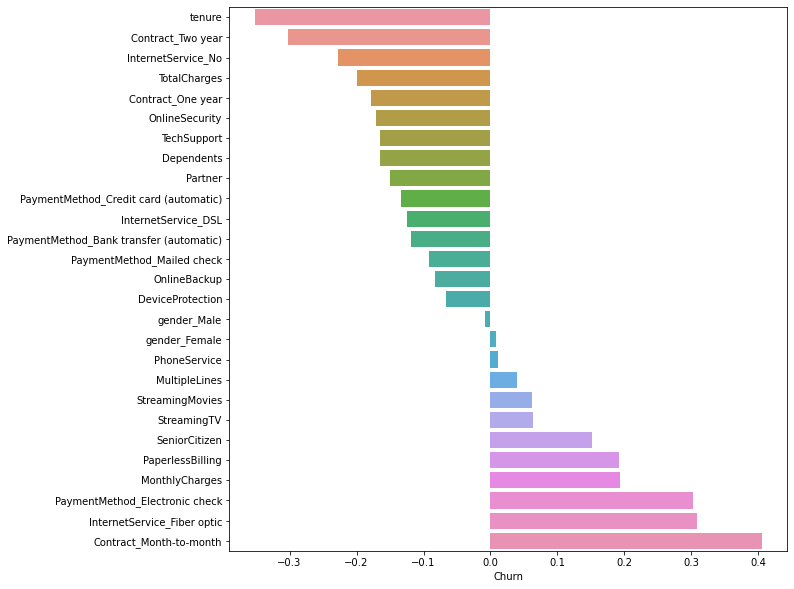

In [95]:
plt.figure(figsize=(10,10))
sns.barplot(x=churn_corrs,y=churn_corrs.index)

We can confirm some of our aforementioned observations with some distribution plots of numerical columns:
 - We see that a long tenure does indeed have a negative correlation with churn. 
    - However, the number of customers that churn after newly joining our services is roughly equal to those who stay
 -  Those offered cheap monthly charges are obviously less likely to churn, but many customers that churn never seemed to get a chance to be offered a cheap plan. Furthermore, plenty of customers with high monthly charges also stay. 
    -  Monthly charges therefore may not be the only cause for churn. 
    - We should therefore examine whether a budget plan (<$40) is only offered to certain types of customers (e.g only two-year contracts, only long tenure customers get budget plans)

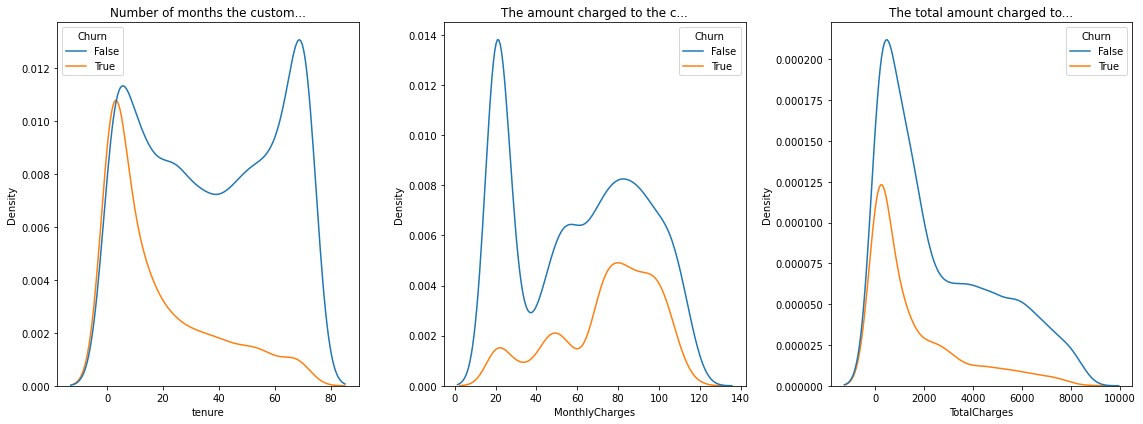

In [226]:
r, c = get_subplot_dim(len(num_cols))
fig, ax = plt.subplots(r,c,figsize=(16,6))
for col, subplot in zip(num_cols,ax.flatten()):
    sub_ax = sns.kdeplot(data=full_data[[col]].join(churn),x=col,hue='Churn',ax=subplot)
    sub_ax.set_title(short_col_desc[col])
plt.tight_layout()

#### Long tenured customers do not necessarily get cheaper plans

From the graph below, it actually seems like most high tenure customers are not getting budget plans since the plot below shows four clusters:
 1. A large cluster of low monthly charge, low tenure customers that stayed
 2. A small cluster of low monthly charge, long tenure customers that stayed
 3. A large cluster of high monthly charge, low tenure customers that churned
 4. A large cluster of high monthly charge, high tenure customers that stayed

 Of these four clusters, the last one's existence seems counter intuitive as a high monthly charge should be chasing people away from the service.  

Text(0.5, 1.0, 'Topography density map of Tenure vs MonthlyCharges')

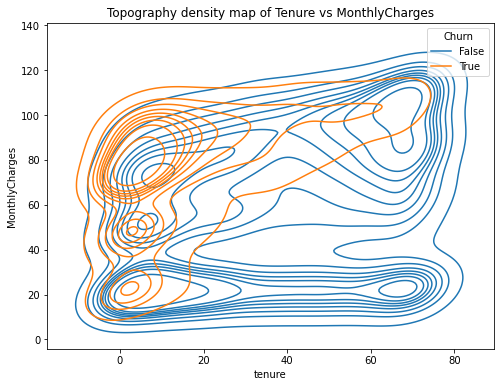

In [279]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    data = full_data[['tenure','MonthlyCharges']].join(churn),
    x='tenure',
    y='MonthlyCharges',
    hue='Churn'
)
plt.title('Topography density map of Tenure vs MonthlyCharges')

However, from the plot below we see that the cluster of people with high monthly charges yet long tenure actually subscribe to a variety of services. These customers therefore stayed because they are indeed getting the bang for their buck and aren't being cheated by being charged a high fee. 

<AxesSubplot: xlabel='High Charge High Tenure', ylabel='Subscribed Services'>

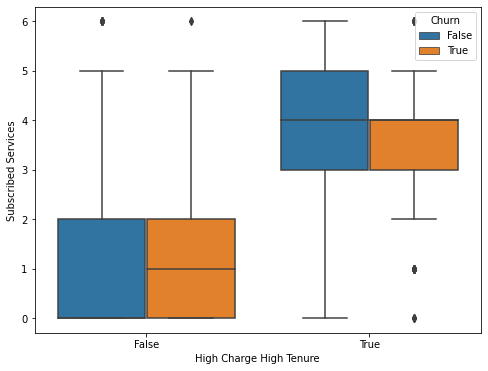

In [288]:
plt.figure(figsize=(8,6))
no_subbed_services = (full_data[internet_cols].drop('InternetService',axis=1)
                      .sum(axis=1).rename('Subscribed Services'))
is_hcht = (full_data.apply(
            lambda x: (x['MonthlyCharges']>40)&(x['tenure']>40),axis=1)
        .rename('High Charge High Tenure'))
sns.boxplot(
    data= (
        no_subbed_services.to_frame().join(is_hcht).join(churn)
    ),
    x='High Charge High Tenure',
    y='Subscribed Services',
    hue='Churn'
)

Furthermore, from the below graph we see that this group of people are actually less likely to churn due to the variety of services they subscribe to and are integrated into their life. 

<AxesSubplot: xlabel='High Charge High Tenure', ylabel='count'>

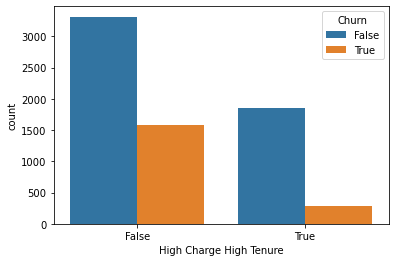

In [285]:
sns.countplot(data = is_hcht.to_frame().join(churn),
              x='High Charge High Tenure',hue='Churn')

### A higher proportion of yearly contracts are cheaper than monthly contracts
Moving onto examining contract types. From the graph below, we see that plenty of Month-to-Month customers still are able to get budget plans, though yearly contract customers have a higher proportion of budget plan customers whereas the bulk of Month-to-Month customers have higher monthly charges. 

<AxesSubplot: xlabel='MonthlyCharges', ylabel='Density'>

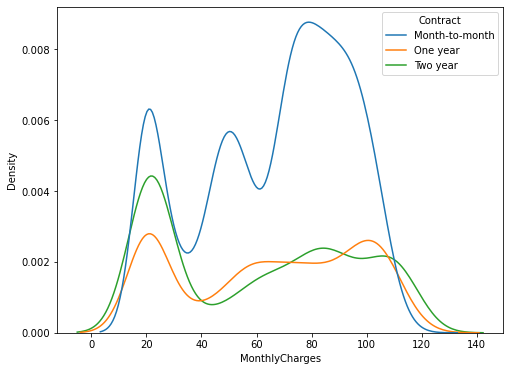

In [157]:
plt.figure(figsize=(8,6))
sns.kdeplot(
    data = full_data,
    x='MonthlyCharges',
    hue='Contract'
)

### Adjusted for contract types, higher monthly charges dramatically affects churn rates

Breaking it down by contract types, however, we see that those who with higher monthly charges within their contract type are indeed much more likely to churn.

<AxesSubplot: xlabel='Contract', ylabel='MonthlyCharges'>

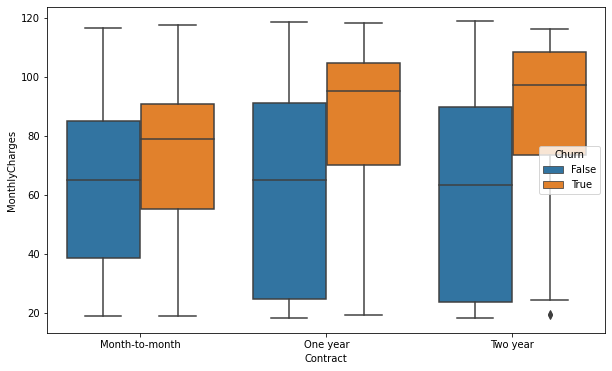

In [237]:
plt.figure(figsize=(10,6))
sns.boxplot(
    data = full_data[['MonthlyCharges','Contract']].join(churn),
    x='Contract',
    y='MonthlyCharges',
    hue='Churn'
)

### Increasing Monthly Charge

From the graph below, we see that the company rarely ever raised the monthly charges of a customer throughout their tenure, be it if they churned or not. 

In [ ]:
lifetime_avg_charge = full_data['TotalCharges']/full_data['tenure']
month_life_avg_diff = churn.to_frame().join(
        (full_data['MonthlyCharges'] 
        - lifetime_avg_charge)
        .rename('Monthly Charge - Lifetime Avg')
    )

<AxesSubplot: xlabel='Monthly Charge - Lifetime Avg', ylabel='Density'>

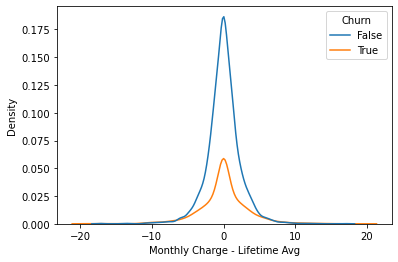

In [178]:
sns.kdeplot(
    data = month_life_avg_diff,
    x='Monthly Charge - Lifetime Avg',
    hue='Churn'
)

From a Mann Whitney U test, we see that the central tendency of monthly charge differences are the same as the pval ≈ 0.69 > α = 0.05. In essence, those who churned in general did not see a significantly higher monthly charge than those who stayed. 

In [187]:
from scipy.stats import mannwhitneyu
mannwhitneyu(
    month_life_avg_diff[
        month_life_avg_diff['Churn']==1
    ]['Monthly Charge - Lifetime Avg'],
    month_life_avg_diff[
        month_life_avg_diff['Churn']==0
    ]['Monthly Charge - Lifetime Avg'],
    nan_policy = 'omit'
)

MannwhitneyuResult(statistic=4854439.5, pvalue=0.6936265492589702)

### Senior Citizens are more likely to churn

From the below plot we see that customers who churned are disproportionally more likely to be senior citizens. 

<AxesSubplot: xlabel='SeniorCitizen', ylabel='Churn %'>

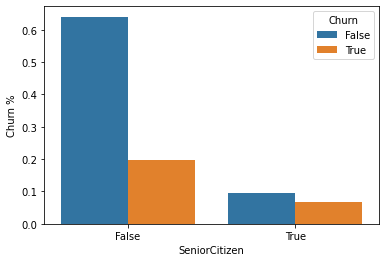

In [209]:
sns.barplot(
    (full_data.join(churn)
        .groupby('SeniorCitizen')['Churn']
        .value_counts()
        /full_data.shape[0]
    ).rename('Churn %').reset_index(),
    x='SeniorCitizen',
    y='Churn %',
    hue='Churn',
)

At first glance looking at the plot below, we may think that SeniorCitizens are more likely to churn since they are charged higher monthly rates. However, looking only at the Senior Citizen violinplot we see that those who didn't churn actually have a higher monthly charge. It is therefore likely Senior Citizens just inherently have a higher churn, and it isn't caused by some indirect variable such as seniors having higher monthly charge. 

<AxesSubplot: xlabel='SeniorCitizen', ylabel='MonthlyCharges'>

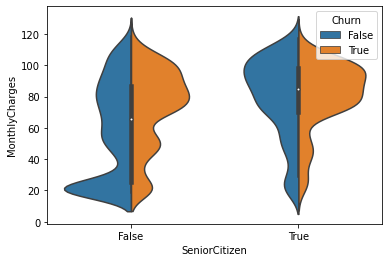

In [223]:
sns.violinplot(
    data=full_data[['MonthlyCharges','SeniorCitizen']].join(churn),
    x='SeniorCitizen',
    y='MonthlyCharges',
    hue='Churn',
    split=True
)

We can first look at how our numerical features correlate with all features. From the heatmap below, we can make the following interesting observations:
 - It seems like long tenured customers are very unlikely to have month-to-month contracts. This is either because customers simply lock themselves into yearly contracts and don't bother churning, or longer contracts are cheaper hence customers don't want to leave. We should later examine whether year long contracts are indeed cheaper. 
 - Monthly Charges also have a high negative correlation to no internet service as well as high correlation to fiber optics internet, meaning a significant portion of a customer's monthly charge is from buying internet services.


<AxesSubplot: >

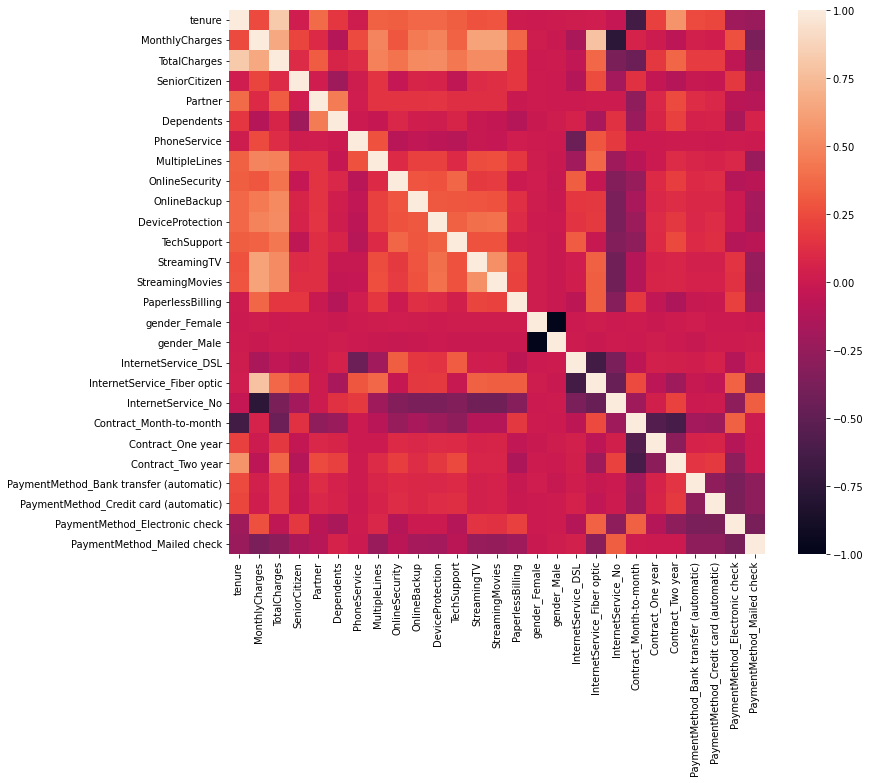

In [238]:
plt.figure(figsize=(12,10))
sns.heatmap(cpu_readable_data.corr())

# Feature Engineering

In [ ]:
from sklearn.cluster import MiniBatchKMeans, OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from graph_utils import graph_elbow

### Number of Internet Services Subscribed to

From our EDA, we found that the number of internet services subscribed may be a good feature to add to our data

In [293]:
full_data['NumInternetServ'] = no_subbed_services

### KMeans Clustering

We can also use KMeans to create clusters and label them to pass as categorical variables to the models later on

In [307]:
pipe = ColumnTransformer([
    (
        'num_pipe',
        Pipeline([
            ('impute',SimpleImputer(strategy='constant',fill_value=0)),
            ('scale',StandardScaler())
        ]),
        num_cols
    ),
],remainder='passthrough')


In [313]:
scaled_data = pipe.fit_transform(cpu_readable_data)

In [314]:
kmeans = []
for i in range(4,cpu_readable_data.shape[1]):
    km = MiniBatchKMeans(n_clusters=i,random_state=RANDOM_SEED)
    km.fit_predict(scaled_data)
    kmeans.append((i,km.inertia_))

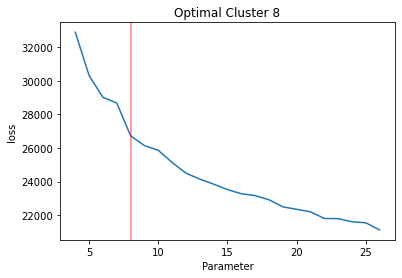

In [347]:
loss = pd.DataFrame(kmeans)[1].rename('loss')
loss.index = loss.index+4
elbow = graph_elbow(loss)

<AxesSubplot: xlabel='km', ylabel='count'>

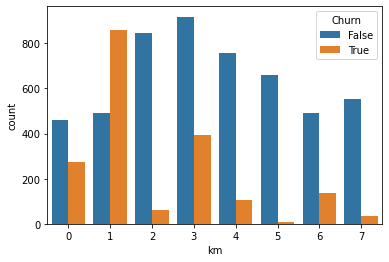

In [348]:
km = MiniBatchKMeans(n_clusters=elbow,random_state=RANDOM_SEED)
full_data['km'] = km.fit_predict(scaled_data)
sns.countplot(data=full_data.join(churn),x='km',hue='Churn')